# Animal classifier usign CNN

## About Dataset and its structure

- I took this dataset from kaggle but this dataset official name is GTSRB - German Traffic Sign Recognition Benchmark, which had been rolled out by Germany.
- This Dataset contains 43 types of traffic signs.
- Structure of data folder


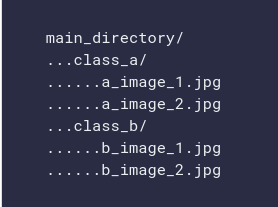

In [1]:
classes = ['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

## 1. Importing the necessary libraries

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
import os
import warnings
import shutil

warnings.filterwarnings("ignore")

- Initializing some useful variables and paths

In [14]:
input_path = "../data/archive/raw-img/"


image_data = []
image_labels = []

# Number of total classes
total_classes = 10

# Batch size
batch_size = 64

# Dimensions of our images
height = 100
width = 100
channels = 3

### Spliting into training and validation sets

In [15]:
# train_data_gen = tf.keras.preprocessing.image_dataset_from_directory(
#     train_path,
#     validation_split = 0.2,
#     subset = "training",
#     seed = 123,
#     image_size = (height, width),
#     batch_size = batch_size
# )
# val_data_gen = tf.keras.preprocessing.image_dataset_from_directory(
#     train_path,
#     validation_split = 0.2,
#     subset = "validation",
#     seed = 123,
#     image_size = (height, width),
#     batch_size = batch_size
# )

### Another method of doing it.

In [16]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                          validation_split = 0.2)

In [28]:
train_image_data = []
train_image_labels = []
for i in classes:
    count = 0
    path = input_path + i
    images = os.listdir(path)
    for img in images:
        temp = cv2.imread(path + "/" + img)
        temp = Image.fromarray(temp, 'RGB')
        temp = temp.resize((height, width))
        train_image_data.append(np.array(temp))
        train_image_labels.append(i)
    print(f"Class {i} completed")

Class butterfly completed
Class cat completed
Class chicken completed
Class cow completed
Class dog completed
Class elephant completed
Class horse completed
Class sheep completed
Class spider completed
Class squirrel completed


In [51]:
image_data = np.array(train_image_data)
image_labels = np.array(train_image_labels)

In [52]:
print(np.shape(train_image_data))
print(np.shape(train_image_labels))

(26179, 100, 100, 3)
(26179,)


In [53]:
# np.savez_compressed("../data/data.npz", train_image_data, train_image_labels)

In [54]:
from sklearn.model_selection import train_test_split

In [65]:
X_train, X_test, y_train, y_test = train_test_split(image_data, image_labels,
                                                    stratify=train_image_labels,
                                                    test_size=0.3
                                                   )

In [66]:
from collections import Counter

print(dict(Counter(y_train)))
print(dict(Counter(y_test)))


{'horse': 1836, 'spider': 3375, 'dog': 3404, 'chicken': 2169, 'cow': 1306, 'squirrel': 1303, 'sheep': 1274, 'butterfly': 1478, 'elephant': 1012, 'cat': 1168}
{'butterfly': 634, 'sheep': 546, 'chicken': 929, 'cat': 500, 'spider': 1446, 'horse': 787, 'cow': 560, 'dog': 1459, 'elephant': 434, 'squirrel': 559}


In [67]:
train_datagen = datagen.flow(X_train, y_train,
                            batch_size = batch_size,
                            subset = "training",
                           shuffle = True)

In [68]:
val_datagen = datagen.flow(X_test, y_test,
                            target_size = (32, 32),
                            batch_size = batch_size,
                            subset = "validation",
                            class_mode='categorical',
                           shuffle = True)

TypeError: flow() got an unexpected keyword argument 'target_size'

## Creating model architecture 

In [19]:
def my_model():
    input_ = tf.keras.layers.Input((32, 32, 3))
    
    net = tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1), padding='valid', activation='relu')(input_)
    net = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(net)
#     net = tf.keras.layers.Dropout(0.2)(net)
    
    net = tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', activation='relu')(net)
    net = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(net)
#     net = tf.keras.layers.Dropout(0.2)(net)
    
    net = tf.keras.layers.Conv2D(64, (7, 7), strides=(1, 1), padding='same', activation='relu')(net)
    net = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    
    net = tf.keras.layers.Flatten()(net)
    net = tf.keras.layers.Dense(72, activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01))(net)
    net = tf.keras.layers.Dense(36, activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01))(net)
    out = tf.keras.layers.Dense(10, activation='softmax')(net)
    
    model = tf.keras.Model(inputs=[input_], outputs=[out])

    model.compile(loss=tf.keras.losses.categorical_crossentropy, 
                  optimizer=tf.keras.optimizers.Adam(lr=0.003), 
                  metrics=['accuracy'])
    model.summary()
    tf.keras.utils.plot_model(model, to_file='./model.png', show_shapes=True)
    return model

In [20]:
model = my_model()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
average_pooling2d_5 (Average (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 32)          12832     
_________________________________________________________________
average_pooling2d_6 (Average (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          100416    
_________________________________________________________________
average_pooling2d_7 (Average (None, 2, 2, 64)          0   

### Defining Callbacks

In [21]:
# Define a Callback class that stops training once accuracy reaches certain limit
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.90 and logs.get('accuracy')>0.93):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True
        
reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.95,
        patience=2,
        verbose=1,
        mode='min',
        min_delta=0.0001,
        cooldown=2,
        min_lr=1e-5
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "../model/model_best.h5", monitor='val_loss', verbose=1, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch'
)

my_callback = myCallback()

In [22]:
history = model.fit_generator(train_datagen,
                               epochs = 50,
                               verbose = 1,
                               validation_data = val_datagen,
                             callbacks=[reduceLROnPlat, my_callback, checkpoint])

Epoch 1/50
 76/328 [=====>........................] - ETA: 16s - loss: 41.8539 - accuracy: 0.1900

KeyboardInterrupt: 

In [ ]:
# model.save("../model/model.h5")

In [ ]:
img = "../data/archive/raw-img/horse/OIP--jy2_p3NvNX51l-FNfOPzAHaFj.jpeg"
def get_output(img):
    img1 = tf.keras.preprocessing.image.load_img(img, target_size=(32, 32), interpolation='bicubic')
    test_img = tf.keras.preprocessing.image.img_to_array(img1, data_format="channels_last")/255
    test_img = np.expand_dims(test_img, axis=0)
    scores = model.predict(test_img)
    prob = np.max(scores, axis = 1)
    preds = np.argmax(scores, axis = 1)
    print(f"{prob[0] * 100}% probability of {classes[preds[0]]}")
get_output(img)